## Creating Birdman plots HCC Data
Date: 9/22/2024
Taken from: https://github.com/ahdilmore/MARS_Birdman/blob/main/birdman/zebra_birdman_analysis.ipynb
  
conda env: comad

#### Imports

In [1]:
import pandas as pd
import qiime2 as q2
import numpy as np
import biom

# plotting 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dict = {
    'blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter': 'blood_HCC_v_CRC/inferences-results/blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter.beta_var.tsv',
}
vars_to_check = {
    'blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter' : 'tumor_type[T.HCC]_'
}

#### Functions

In [3]:
def read_results(p):
    return pd.read_csv(p, sep='\t', index_col='Feature')

def unpack_hdi_and_filter(df, col):
    #HDI: High Density Interval -- highest density interval of posterial distributions
    #This is also known as the minimum width Bayesian credible interval
    #https://python.arviz.org/en/stable/api/generated/arviz.hdi.html --> package for how this was calcualted
    #also in other scripts where Hazel added this (was not the default from Gibs)
    #Reason for adding is a lot of the means have insane std. dev. and so this is giving us a full range
    #and allowing us to remove things that have 0 in thier range
    
    #This comes in a string so subsetting it
    df[['lower', 'upper']] = df[col].str.split(',', expand=True)
    # remove ( from lower and ) from upper and convert to float 
    df.lower = df.lower.str[1:].astype('float')
    df.upper = df.upper.str[:-1].astype('float')
    
    #Drop any interval where 0 is in the interval because then clearly not a strong indicater
    df['credible'] = np.where((df.lower > 0) | (df.upper < 0), 'yes', 'no')
    
    #This is used just to plot the lines before and after the dots
    df.upper = df.upper - df[col.replace('hdi', 'mean')]
    df.lower = df[col.replace('hdi', 'mean')] - df.lower
    
    return df

In [4]:
def display_top_n_feats(fn, df, n, yvar, xvar, xlab, ylab, title):
    #n : displays the top and bottom n if there are more than n features
    
    if df.shape[0] < 2*n: 
        df_for_display = df 
    else: 
        bottomn = df[:n]
        topn = df[-1*n:]
        df_for_display = pd.concat([bottomn, topn])
    
    '''
    sns.stripplot(data=df_for_display, y=yvar, x=xvar, ax=ax)
    plt.errorbar(data=df_for_display, 
                 x=xvar, y=yvar,
                 xerr=df_for_display[['lower', 'upper']].T, ls='none')
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    '''
    # Set your desired figure size (adjust width and height as needed)
    fig, ax = plt.subplots(figsize=(17, 7))

    # Create strip plot
    sns.stripplot(data=df_for_display, y=yvar, x=xvar, ax=ax)

    # Add error bars
    plt.errorbar(data=df_for_display, x=xvar, y=yvar,
                 xerr=df_for_display[['lower', 'upper']].T, ls='none')

    # Set labels and title
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    
    plt.tight_layout()
    
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
    
    plt.savefig('figures/' + fn + '.svg')
    plt.show()
    
    display(df_for_display)
    print(list(df_for_display['Feature']))
    
    df_for_display.to_csv('figures/' + fn + '.tsv', sep='\t', index =False)
    

In [5]:
#Create RS210 taxanomy into a useable dic 
rs210 = pd.read_csv('/scratch/qp-woltka/RS210/RS210.tax', sep='\t', header=None, index_col=0)
rs210_dict = rs210[1].to_dict() 

def add_taxonomy_col_rs210(df):
    
    # Convert gOTUS into readable taxonomy
    df['Taxonomy'] = df['Feature'].map(rs210_dict)
    
    #Create label with gOTU and taxonomu
    df['gOTU_Taxonomy'] = df['Feature'] + ' : ' + df['Taxonomy']


#### Code

In [6]:
# update names 
for k in data_dict.keys():
    df = read_results(data_dict[k])
    for v in vars_to_check: 
        if v in k: 
            var = vars_to_check[v] 
    print(k)
    print('Unfiltered Shape:  ' + str(df.shape))
    sub_df = unpack_hdi_and_filter(df, var+'hdi')
    print('Filtered Shape: ' + str(sub_df.loc[sub_df['credible'] == 'yes'].shape))
    sub_df.rename_axis(index='Feature', inplace=True)
    
    data_dict[k] = sub_df.sort_values(by=var+'mean')

blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter
Unfiltered Shape:  (469, 6)
Filtered Shape: (65, 9)


#### Plotting

tumor_type[T.HCC]_


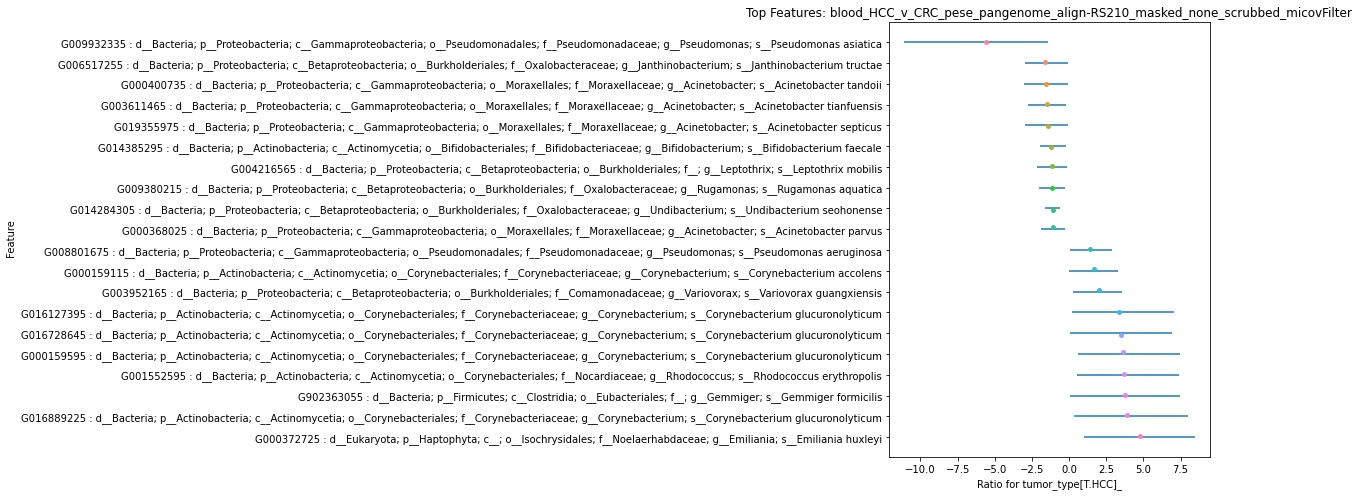

,Feature,Intercept_mean,tumor_type[T.HCC]_mean,Intercept_std,tumor_type[T.HCC]_std,Intercept_hdi,tumor_type[T.HCC]_hdi,lower,upper,credible,Taxonomy,gOTU_Taxonomy
0,G009932335,-7.999350,-5.611520,0.784210,2.725345,"(-9.38161, -6.64678)","(-11.1273, -1.42282)",5.515780,4.188700,yes,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,G009932335 : d__Bacteria; p__Proteobacteria; c...
19,G006517255,-6.609340,-1.589161,0.557383,0.755503,"(-7.6185, -5.53781)","(-2.97067, -0.0811562)",1.381509,1.508004,yes,d__Bacteria; p__Proteobacteria; c__Betaproteob...,G006517255 : d__Bacteria; p__Proteobacteria; c...
21,G000400735,-7.520462,-1.521766,0.565901,0.795501,"(-8.57489, -6.51001)","(-3.06068, -0.100368)",1.538914,1.421398,yes,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,G000400735 : d__Bacteria; p__Proteobacteria; c...
22,G003611465,-7.263698,-1.501566,0.461927,0.671154,"(-8.15338, -6.39853)","(-2.73753, -0.223938)",1.235964,1.277628,yes,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,G003611465 : d__Bacteria; p__Proteobacteria; c...
24,G019355975,-7.569782,-1.453004,0.551478,0.768251,"(-8.59294, -6.58348)","(-2.98534, -0.0983917)",1.532336,1.354612,yes,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,G019355975 : d__Bacteria; p__Proteobacteria; c...
31,G014385295,-6.515199,-1.201248,0.354074,0.469360,"(-7.19579, -5.92026)","(-1.94891, -0.200701)",0.747662,1.000547,yes,d__Bacteria; p__Actinobacteria; c__Actinomycet...,G014385295 : d__Bacteria; p__Actinobacteria; c...
35,G004216565,-6.923309,-1.151724,0.395453,0.533601,"(-7.63841, -6.18056)","(-2.15211, -0.147647)",1.000386,1.004077,yes,d__Bacteria; p__Proteobacteria; c__Betaproteob...,G004216565 : d__Bacteria; p__Proteobacteria; c...
36,G009380215,-6.267826,-1.141177,0.362591,0.463333,"(-6.96633, -5.6473)","(-2.00647, -0.258371)",0.865293,0.882806,yes,d__Bacteria; p__Proteobacteria; c__Betaproteob...,G009380215 : d__Bacteria; p__Proteobacteria; c...
37,G014284305,-5.313270,-1.110851,0.202114,0.259932,"(-5.72485, -4.94679)","(-1.61112, -0.62874)",0.500269,0.482111,yes,d__Bacteria; p__Proteobacteria; c__Betaproteob...,G014284305 : d__Bacteria; p__Proteobacteria; c...
38,G000368025,-6.666869,-1.105827,0.336687,0.450329,"(-7.29953, -6.05201)","(-1.91755, -0.274167)",0.811723,0.831660,yes,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,G000368025 : d__Bacteria; p__Proteobacteria; c...


['G009932335', 'G006517255', 'G000400735', 'G003611465', 'G019355975', 'G014385295', 'G004216565', 'G009380215', 'G014284305', 'G000368025', 'G008801675', 'G000159115', 'G003952165', 'G016127395', 'G016728645', 'G000159595', 'G001552595', 'G902363055', 'G016889225', 'G000372725']


In [7]:
for k in data_dict.keys(): 
    for v in vars_to_check.keys(): 
        if v in k:
            print(var)
            xlab = 'Ratio for ' + var
            var = vars_to_check[v]
    
    ylab = ' Feature'
    df_for_display = data_dict[k].reset_index()
    df_for_display = df_for_display.loc[df_for_display.credible == 'yes']

    add_taxonomy_col_rs210(df_for_display)

    display_top_n_feats('blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter',df_for_display, 10, 'gOTU_Taxonomy', var+'mean', xlab, ylab,'Top Features: ' + k)